In [1]:
import pandas as pd
import yfinance as yahooFinance
import os
# import pandas_ta as ta  # Technical Analysis Library
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle 
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [3]:

symbol_df = pd.read_csv('../data/ind_nifty500list.csv')

In [4]:
symbol_df.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,360 ONE WAM Ltd.,Financial Services,360ONE,EQ,INE466L01038
1,3M India Ltd.,Diversified,3MINDIA,EQ,INE470A01017
2,ABB India Ltd.,Capital Goods,ABB,EQ,INE117A01022
3,ACC Ltd.,Construction Materials,ACC,EQ,INE012A01025
4,ACME Solar Holdings Ltd.,Power,ACMESOLAR,EQ,INE622W01025


In [20]:
GetFacebookInformation = yahooFinance.Ticker(f'ACC.NS')
df = GetFacebookInformation.history(period="max")

In [23]:
df = df.reset_index()

In [24]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-07-01 00:00:00+05:30,109.663863,111.720061,108.978464,110.863312,659631,0.0,0.0
1,2002-07-02 00:00:00+05:30,110.383527,111.959947,109.663856,109.938011,282660,0.0,0.0
2,2002-07-03 00:00:00+05:30,110.349271,111.034671,108.875667,109.526794,500553,0.0,0.0
3,2002-07-04 00:00:00+05:30,109.081273,110.280721,107.950368,108.293068,284181,0.0,0.0
4,2002-07-05 00:00:00+05:30,108.327334,109.492510,107.676207,107.984634,252587,0.0,0.0
...,...,...,...,...,...,...,...,...
5725,2025-07-23 00:00:00+05:30,1967.900024,1967.900024,1915.300049,1950.000000,569821,0.0,0.0
5726,2025-07-24 00:00:00+05:30,1953.900024,1956.099976,1887.000000,1890.000000,1106140,0.0,0.0
5727,2025-07-25 00:00:00+05:30,1889.900024,1904.800049,1845.000000,1847.699951,648049,0.0,0.0
5728,2025-07-28 00:00:00+05:30,1847.699951,1857.699951,1821.000000,1825.599976,562103,0.0,0.0


In [5]:

for i in tqdm(range(len(symbol_df))):
    
    GetFacebookInformation = yahooFinance.Ticker(f'{symbol_df["Symbol"][i]}.NS')
    df = GetFacebookInformation.history(period="max")
    df = df.reset_index()
    df.to_csv(f'../data/stock_data/{symbol_df["Symbol"][i]}.csv',index=False)

 29%|██▊       | 143/501 [01:04<02:32,  2.34it/s]HTTP Error 404: 
$DUMMYDBRLT.NS: possibly delisted; no timezone found
100%|██████████| 501/501 [03:57<00:00,  2.11it/s]


In [6]:
directory = "../data/stock_data"

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)  # Read CSV into a DataFrame
        df['Date'] = pd.to_datetime(df['Date'])
        df['Day'] = df['Date'].dt.day_name()
        df = df[df['Date'] < '2025-05-01']
        # df = df.loc[:, ~df.columns.str.startswith("Unnamed")]
        df.to_csv(f'../data/stock_data/{filename.split(".")[0]}.csv',index=False)


In [4]:
df = pd.read_csv('../data/stock_data/RELIANCE.csv')

In [ ]:
df = df[df['Date'] > '2024-01-01T00:00:00+05:30']

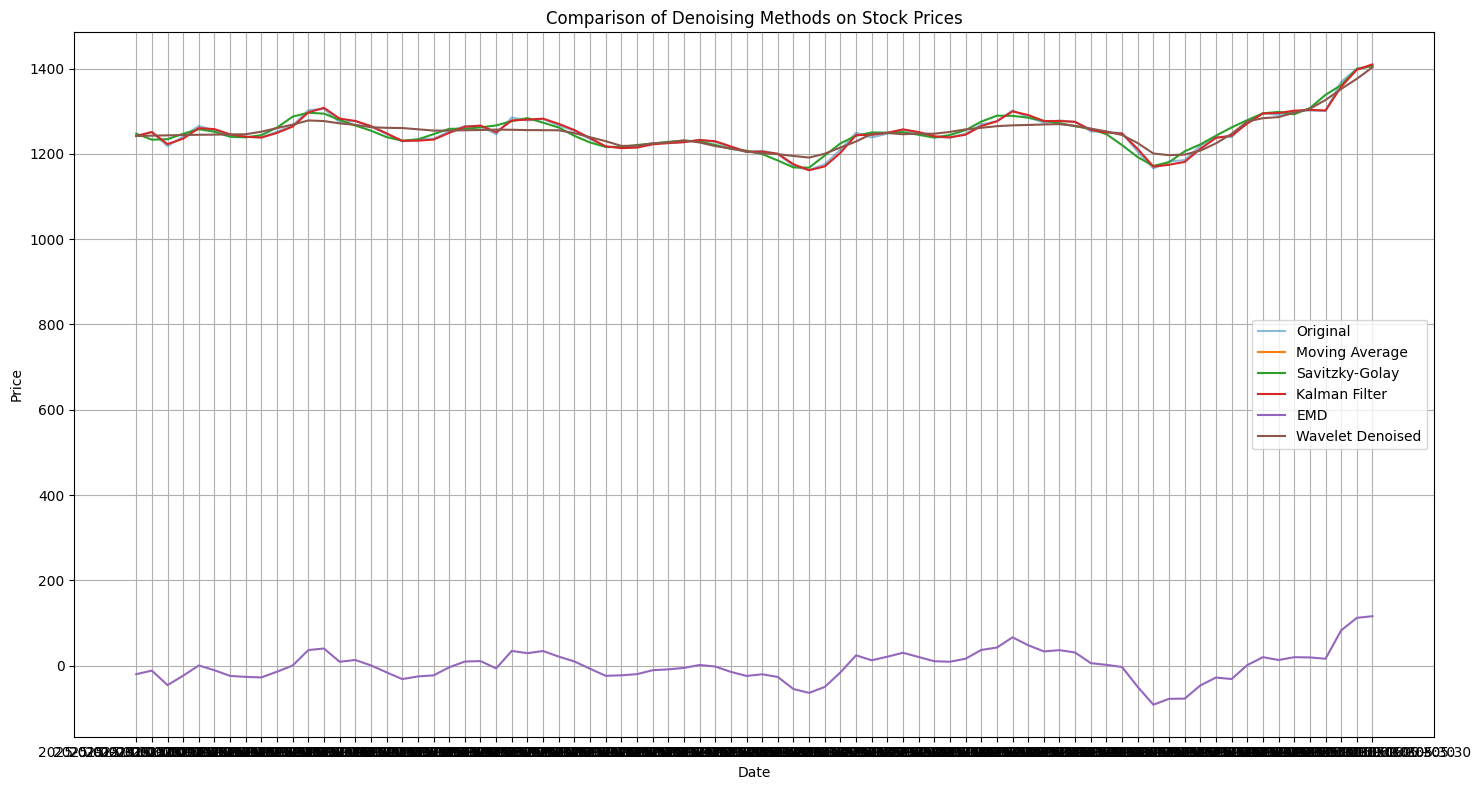

In [11]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from filterpy.kalman import KalmanFilter
from PyEMD import EMD

# Assuming df['Date'] and df['Close'] are defined and filtered

signal = df['Close'].values
dates = df['Date'].values
df = df[df['Date'] > '2025-01-01T00:00:00+05:30']
# 1. Moving Average
window = 6
df['MA'] = pd.Series(signal).rolling(window=window).mean().fillna(method='bfill')

# 2. Savitzky-Golay Filter
df['SG'] = savgol_filter(signal, window_length=6, polyorder=3)

# 3. Kalman Filter (1D Simplified)
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([[signal[0]], [0]])          # initial state (location and velocity)
kf.F = np.array([[1, 1], [0, 1]])             # state transition matrix
kf.H = np.array([[1, 0]])                    # Measurement function
kf.P *= 1000                                 # covariance matrix
kf.R = 1                                     # measurement noise
kf.Q = np.eye(2)                             # process noise

kalman_output = []
for z in signal:
    kf.predict()
    kf.update(z)
    kalman_output.append(kf.x[0][0])
df['Kalman'] = kalman_output

# 4. EMD
emd = EMD()
imfs = emd(signal)
residue = np.sum(imfs[:-1], axis=0)  # leave last IMF (usually high freq)
df['EMD'] = residue[:len(df)]

# 5. Wavelet Denoising (already done)
wavelet = 'db3'
level = 4
coeffs = pywt.wavedec(signal, wavelet, level=level)
threshold = np.sqrt(2 * np.log(len(signal))) * (np.median(np.abs(coeffs[-1])) / 0.6745)
denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
df['Wavelet'] = pywt.waverec(denoised_coeffs, wavelet)[:len(df)]

# Plot all
plt.figure(figsize=(15, 8))
plt.plot(df['Date'], df['Close'], label='Original', alpha=0.5)
plt.plot(df['Date'], df['MA'], label='Moving Average')
plt.plot(df['Date'], df['SG'], label='Savitzky-Golay')
plt.plot(df['Date'], df['Kalman'], label='Kalman Filter')
plt.plot(df['Date'], df['EMD'], label='EMD')
plt.plot(df['Date'], df['Wavelet'], label='Wavelet Denoised')
plt.legend()
plt.title('Comparison of Denoising Methods on Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
df.head(20)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Day,Close_Denoised
0,1996-01-01 00:00:00+05:30,4.618592,4.643374,4.588176,4.635489,104121369,0.0,0.0,Monday,4.535717
1,1996-01-02 00:00:00+05:30,4.624225,4.646754,4.565647,4.599442,168743308,0.0,0.0,Tuesday,4.525307
2,1996-01-03 00:00:00+05:30,4.674916,4.887822,4.624225,4.634363,209323879,0.0,0.0,Wednesday,4.515138
3,1996-01-04 00:00:00+05:30,4.590429,4.605073,4.529599,4.591556,216900264,0.0,0.0,Thursday,4.504487
4,1996-01-05 00:00:00+05:30,4.573532,4.573532,4.520587,4.560014,166708467,0.0,0.0,Friday,4.474884
5,1996-01-08 00:00:00+05:30,4.551003,4.554382,4.332464,4.377523,186974245,0.0,0.0,Monday,4.437015
6,1996-01-09 00:00:00+05:30,4.247978,4.325705,4.106041,4.251358,388766555,0.0,0.0,Tuesday,4.399467
7,1996-01-10 00:00:00+05:30,4.167997,4.268254,4.122938,4.142087,276606655,0.0,0.0,Wednesday,4.356174
8,1996-01-11 00:00:00+05:30,4.100408,4.291911,4.094776,4.271634,409645726,0.0,0.0,Thursday,4.317098
9,1996-01-12 00:00:00+05:30,4.303175,4.335843,4.198412,4.226574,374687924,0.0,0.0,Friday,4.277157


In [5]:
# Convert data into time-series sequences
def create_sequences(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(labels[i + seq_length])
    return np.array(X), np.array(y)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# === 3️⃣ Define CNN-LSTM Model ===
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers, output_dim):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # LSTM input (batch_size, sequence_length, input_size) and output (batch, seq length, hidden size)
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape for Conv1D
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Change back for LSTM
        lstm_out, _ = self.lstm(x)
        # print(lstm_out.shape)
        # print(lstm_out[:,-1,:].shape)
        x = self.fc(lstm_out[:, -1, :])
        return self.sigmoid(x)

In [13]:
def add_features(file_path):
    df = pd.read_csv(file_path)
    df = df[df['Date'] < '2025-02-14 00:00:00+05:30']


    # Ensure Date is a proper datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)


    # Trend Indicators
    df['SMA_10'] = df.ta.sma(length=10)  # Simple Moving Average
    df['SMA_20'] = df.ta.sma(length=20)
    df['SMA_50'] = df.ta.sma(length=50)
    df['SMA_100'] = df.ta.sma(length=100)
    # df['SMA_200'] = df.ta.sma(length=200)
    df['EMA_5'] = df.ta.ema(length=5)
    df['EMA_9'] = df.ta.ema(length=9)  # Exponential Moving Average
    df['EMA_20'] = df.ta.ema(length=20)
    df['EMA_50'] = df.ta.ema(length=50)
    df['EMA_100'] = df.ta.ema(length=100)
    # df['EMA_200'] = df.ta.ema(length=200)
    
    df['ADX'] = df.ta.adx(length=14)['ADX_14']
    
    df['A/D'] = df.ta.ad()

    df['RSI'] = df.ta.rsi(length=14)  # Relative Strength Index
    
    df[['StochK_14_3_3_14', 'StochD_14_3_3_14']] = df.ta.stoch()  # Stochastic Oscillator
    df[['StochK_3_3_14_14', 'StochD_3_3_14_14']] = df.ta.stoch(k=3,d=3,smooth_k=14)
    
    df['WilliamsR'] = df.ta.willr()  # Williams %R

    # Volume-Based Indicators
    df['OBV'] = df.ta.obv()  # On-Balance Volume
    df['VWAP'] = df.ta.vwap()  # Volume Weighted Average Price

    # Volatility Indicators
    df['ATR'] = df.ta.atr()  # Average True Range
    df['StdDev'] = df.ta.stdev(length=20)  # Standard Deviation
    
    df = df[df['Day'] == 'Friday']

    # === Define Weekly Trading Signals (Target Variable) ===
    df['Signal'] = np.where(df['Close'].shift(-1) > (df['Close'] + df['Close']*0.03), 1, 0)  # 1 = Buy, 0 = Sell

    # Drop NaN values that may have been introduced
    df.dropna(inplace=True)

    # === Prepare Data for XGBoost ===
    features = df.drop(columns=['Signal','Dividends', 'Stock Splits','Day']).values
    target = df['Signal'].values

    return features,target

In [14]:
accuracies = {}

hidden_dim = 128  # Number of LSTM neurons
lstm_layers = 2   # Stacked LSTM layers
output_dim = 1
batch_size = 16
num_epochs = 50
seq_length = 4 # Lookback period



# === Load Stock Data ===
directory = "../data/stock_data"

# Loop through all files in the directory
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(directory, filename)
        
        try:

            features, target = add_features(file_path)
            
            # === 2️⃣ Train-Test Split (WITHOUT SHUFFLING) ===
            train_size = int(len(features) * 0.8)
            X_train, X_test = features[:train_size], features[train_size:]
            y_train, y_test = target[:train_size], target[train_size:]

            # Apply Standard Scaler AFTER splitting (to prevent data leakage)
            scaler = StandardScaler()

            # Fit the scaler on training data
            std_model = scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

            # Transform both train and test sets using the fitted scaler
            X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            

            # Create sequences
            X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
            X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, seq_length)

            # Convert to PyTorch tensors
            X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
            y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32).to(device)
            X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
            y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32).to(device)
            
            pickle.dump(std_model, open(f'../data/standard_scaler/{filename.split(".")[0]}.pkl', "wb"))

            input_dim = X_train_seq.shape[2]    

            model = CNN_LSTM(input_dim, hidden_dim, lstm_layers, output_dim).to(device)
            

            # Define Loss & Optimizer
            criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
            optimizer = optim.Adam(model.parameters(), lr=0.001)


            # Create dataset
            train_dataset = TensorDataset(X_train_seq, y_train_seq)

            # Create DataLoader
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

            # === Train LSTM Model ===

            for epoch in range(num_epochs):
                model.train()
                
                for batch_X, batch_y in train_loader:  # Iterate through mini-batches
                    optimizer.zero_grad()
                    outputs = model(batch_X.to(device))  # Forward pass
                    outputs = outputs.view(-1, 1)  # Ensure correct shape
                    batch_y = batch_y.view(-1, 1)  # Ensure correct shape
                    loss = criterion(outputs, batch_y.to(device))  # Compute loss
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update weights

                # if epoch % 10 == 0:
                #     print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

            # === Evaluate Model ===
            model.eval()
            with torch.no_grad():
                y_pred = model(X_test_seq.to(device))
                y_pred_binary = (y_pred > 0.5).float()
                accuracy = accuracy_score(y_test_seq.cpu().numpy(), y_pred_binary.cpu().numpy())
                
            accuracies[f'{filename.split(".")[0]}'] = accuracy

            # === Save Weekly Predictions ===
            # df['Predicted_Signal'] = model.predict(xgb.DMatrix(features))
            # df['Predicted_Signal'] = np.where(df['Predicted_Signal'] > 0.5, 1, 0)

            # df.to_csv(f'../data/pred_data/pred_{filename.split(".")[0]}.csv',index=False)

            # save
            pickle.dump(model, open(f'../data/model/xgb_{filename.split(".")[0]}.pkl', "wb"))
        except Exception as e:
            print(f'Error in {filename}: {e}')

  4%|▍         | 19/495 [01:09<18:58,  2.39s/it]

Error in AADHARHFC.csv: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 3


  4%|▍         | 21/495 [01:16<28:54,  3.66s/it]


KeyboardInterrupt: 

In [4]:

header = ['Stock', 'accuracy']
with open('../data/accuracies.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(header)
    for key, value in accuracies.items():
       writer.writerow([key, value])

In [7]:

for i in range(len(symbol_df)):
    
    GetFacebookInformation = yahooFinance.Ticker(f'{symbol_df["Stock"][i]}.NS')
    df = GetFacebookInformation.history(period="6mo")
    df.to_csv(f'../data/fut_data/{symbol_df["Stock"][i]}.csv')

In [ ]:
directory = "../data/fut_data"
fut_pred = {}

# Loop through all files in the directory
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(directory, filename)
        try:
            input_data = pd.read_csv(file_path)
            # print(filename)
            
            input_data['Date'] = pd.to_datetime(input_data['Date'])
            
            # input_data = input_data[input_data['Date'] < '2025-02-01 00:00:00+05:30']
            # print(input_data)
            input_data.set_index('Date', inplace=True)

            input_data['SMA_10'] = input_data.ta.sma(length=10)  # Simple Moving Average
            input_data['SMA_20'] = input_data.ta.sma(length=20)
            input_data['SMA_50'] = input_data.ta.sma(length=50)
            input_data['SMA_100'] = input_data.ta.sma(length=100)
            # input_data['SMA_200'] = input_data.ta.sma(length=200)
            
            input_data['EMA_5'] = input_data.ta.ema(length=5)
            input_data['EMA_9'] = input_data.ta.ema(length=9)  # Exponential Moving Average
            input_data['EMA_20'] = input_data.ta.ema(length=20)
            input_data['EMA_50'] = input_data.ta.ema(length=50)
            input_data['EMA_100'] = input_data.ta.ema(length=100)
            # input_data['EMA_200'] = input_data.ta.ema(length=200)
            
            input_data['ADX'] = input_data.ta.adx(length=14)['ADX_14']
            
            input_data['A/D'] = input_data.ta.ad()

            input_data['RSI'] = input_data.ta.rsi(length=14)  # Relative Strength Index
            # input_data[['StochK', 'StochD']] = input_data.ta.stoch()  # Stochastic Oscillator
            input_data[['StochK_14_3_3_14', 'StochD_14_3_3_14']] = input_data.ta.stoch()  # Stochastic Oscillator
            input_data[['StochK_3_3_14_14', 'StochD_3_3_14_14']] = input_data.ta.stoch(k=3,d=3,smooth_k=14)
                
            input_data['WilliamsR'] = input_data.ta.willr()  # Williams %R

            # Volume-Based Indicators
            input_data['OBV'] = input_data.ta.obv()  # On-Balance Volume
            input_data['VWAP'] = input_data.ta.vwap()  # Volume Weighted Average Price

            # Volatility Indicators
            input_data['ATR'] = input_data.ta.atr()  # Average True Range
            input_data['StdDev'] = input_data.ta.stdev(length=20)  # Standard Deviation
            # print(input_data.head(5))

            features = input_data[input_data.index == '2025-02-14 00:00:00+05:30']
            features = features.drop(columns=['Dividends', 'Stock Splits'])
            std_model = pickle.load(open(f'../data/standard_scaler/{filename.split(".")[0]}.pkl', 'rb'))
            scaled_feat = pd.DataFrame(std_model.transform(features), columns=features.columns, index=features.index)

            # print(features)
            dinput = xgb.DMatrix(scaled_feat)
            loaded_model = pickle.load(open(f'../data/model/xgb_{filename.split(".")[0]}.pkl', 'rb'))
            predictions = loaded_model.predict(dinput)
            predictions_binary = np.where(predictions > 0.5, 1, 0)
            fut_pred[f'{filename.split(".")[0]}'] = [predictions_binary,predictions[0]]
        except Exception as e:
            print(f'Error in {filename}: {e}')

100%|██████████| 495/495 [00:25<00:00, 19.63it/s]


In [9]:
weekly_prediction = pd.DataFrame(
    [(symbol, values[0][0], values[1]) for symbol, values in fut_pred.items()],
    columns=["Stock", "Signal", "Probability"]
)

In [10]:
acc = pd.read_csv('../data/accuracies.csv')

In [11]:
weekly_prediction = weekly_prediction.merge(acc, on='Stock', how='inner')

In [13]:
weekly_prediction.to_csv('../data/weekly_prediction(17feb-21feb).csv',index=False)

In [6]:
weekly_prediction = pd.read_csv('../data/weekly_prediction(10feb-14feb).csv')

In [12]:
weekly_prediction[(weekly_prediction['Signal'] == 1)]

,Stock,Signal,Probability,accuracy
15,ADANIENSOL,1,0.650211,0.727273
16,VBL,1,0.603548,0.649351
24,UNIONBANK,1,0.543520,0.604651
67,360ONE,1,0.574833,0.632653
75,GMDCLTD,1,0.659722,0.658986
86,GRAPHITE,1,0.641523,0.649770
88,TRENT,1,0.507081,0.709677
97,IREDA,1,0.647904,0.777778
132,KALYANKJIL,1,0.530880,0.617647
135,MPHASIS,1,0.613158,0.686636


In [19]:
weekly_prediction[(weekly_prediction['Signal'] == 1)]

,Stock,Signal,Probability,accuracy
4,NEWGEN,1,0.526798,0.712121
10,ESCORTS,1,0.519980,0.607143
15,ADANIENSOL,1,0.784867,0.818182
23,SHYAMMETL,1,0.647038,0.625000
33,ADANIGREEN,1,0.590516,0.688525
...,...,...,...,...
456,HAPPSTMNDS,1,0.734465,0.775000
466,MANKIND,1,0.757520,0.785714
469,COALINDIA,1,0.666500,0.705882
477,PPLPHARMA,1,0.963677,0.631579


In [20]:
weekly_prediction[(weekly_prediction['Signal'] == 1)&(weekly_prediction['accuracy'] < 0.7)]

,Stock,Signal,Probability,accuracy
10,ESCORTS,1,0.519980,0.607143
23,SHYAMMETL,1,0.647038,0.625000
33,ADANIGREEN,1,0.590516,0.688525
57,NCC,1,0.644144,0.581731
67,360ONE,1,0.688471,0.530612
86,GRAPHITE,1,0.504751,0.626728
125,IDEA,1,0.806760,0.578947
185,DATAPATTNS,1,0.607660,0.607143
206,FACT,1,0.784169,0.668203
215,RVNL,1,0.629563,0.698113


- IDEA


In [10]:
success_stocks = []
for i in tqdm(range(len(symbol_df))):
    try:
        GetFacebookInformation = yahooFinance.Ticker(f'{symbol_df["Stock"][i]}.NS')
        df = GetFacebookInformation.history(period="1mo")
        df.reset_index(level=0,inplace=True)
        target_date = '2025-02-07 00:00:00+05:30'
        target_column = df[df['Date'] == target_date]
        df = df[df['Date'] > target_date].drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],axis=1)
        df['Target Close'] = target_column['Close'].values[0]
        df['Difference'] = df['Close'] - df['Target Close']
        df['Percentage'] = df['Difference'] / df['Target Close'] *100
        prediction_data = weekly_prediction[weekly_prediction['Stock'] == symbol_df["Stock"][i]]
        df['Signal'] = prediction_data['Signal'].values[0]
        df['Probability'] = prediction_data['Probability'].values[0]
        df['accuracy'] = prediction_data['accuracy'].values[0]
        if((df['Percentage'] > 3) &(df['Signal'] == 1)).any():
            success_stocks.append([symbol_df["Stock"][i], prediction_data['Probability'].values[0], prediction_data['accuracy'].values[0]])
        df.to_csv(f'../data/after_week_pred/{symbol_df["Stock"][i]}.csv',index=False)
    except Exception as e:
        print(f'Error in {symbol_df["Stock"][i]}: {e}')

 14%|█▍        | 69/495 [00:16<01:39,  4.29it/s]

Error in BERGEPAINT: index 0 is out of bounds for axis 0 with size 0


 29%|██▉       | 143/495 [00:36<03:59,  1.47it/s]

Error in EICHERMOT: "['Dividends', 'Stock Splits'] not found in axis"


100%|██████████| 495/495 [01:59<00:00,  4.14it/s]


In [11]:
success_stocks

[]

In [16]:
failed_stocks = []
for i in tqdm(range(len(symbol_df))):
    try:
        GetFacebookInformation = yahooFinance.Ticker(f'{symbol_df["Stock"][i]}.NS')
        df = GetFacebookInformation.history(period="1mo")
        df.reset_index(level=0,inplace=True)
        target_date = '2025-02-07 00:00:00+05:30'
        target_column = df[df['Date'] == target_date]
        df = df[df['Date'] > target_date].drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],axis=1)
        df['Target Close'] = target_column['Close'].values[0]
        df['Difference'] = df['Close'] - df['Target Close']
        df['Percentage'] = df['Difference'] / df['Target Close'] *100
        prediction_data = weekly_prediction[weekly_prediction['Stock'] == symbol_df["Stock"][i]]
        df['Signal'] = prediction_data['Signal'].values[0]
        df['Probability'] = prediction_data['Probability'].values[0]
        df['accuracy'] = prediction_data['accuracy'].values[0]
        if((df['Percentage'] > 3) &(df['Signal'] == 0)).any():
            failed_stocks.append([symbol_df["Stock"][i], prediction_data['Probability'].values[0], prediction_data['accuracy'].values[0]])
        # df.to_csv(f'../data/after_week_pred/{symbol_df["Stock"][i]}.csv',index=False)
    except Exception as e:
        print(f'Error in {symbol_df["Stock"][i]}: {e}')

 14%|█▍        | 69/495 [00:16<01:38,  4.34it/s]

Error in BERGEPAINT: index 0 is out of bounds for axis 0 with size 0


 29%|██▊       | 142/495 [00:35<06:42,  1.14s/it]

Error in EICHERMOT: "['Dividends', 'Stock Splits'] not found in axis"


100%|██████████| 495/495 [01:52<00:00,  4.40it/s]


In [18]:
failed_stocks

[['ASHOKLEY', np.float64(0.0075118043), np.float64(0.6175115207373272)],
 ['AVANTIFEED', np.float64(0.057998717), np.float64(0.6428571428571429)],
 ['BAJAJHLDNG', np.float64(0.016203845), np.float64(0.7323943661971831)],
 ['CAMPUS', np.float64(0.22302644), np.float64(0.6666666666666666)],
 ['ENGINERSIN', np.float64(0.0021588914), np.float64(0.649402390438247)],
 ['FLUOROCHEM', np.float64(0.12419982), np.float64(0.5833333333333334)],
 ['GODFRYPHLP', np.float64(0.04881004), np.float64(0.7349397590361446)],
 ['HAPPSTMNDS', np.float64(0.38896373), np.float64(0.8717948717948718)],
 ['HONASA', np.float64(0.049595855), np.float64(0.8888888888888888)],
 ['INOXWIND', np.float64(0.06384885), np.float64(0.6847826086956522)],
 ['MUTHOOTFIN', np.float64(0.13438104), np.float64(0.7)],
 ['REDINGTON', np.float64(0.0152836535), np.float64(0.6198830409356725)],
 ['SBICARD', np.float64(0.087116845), np.float64(0.8181818181818182)],
 ['SCHNEIDER', np.float64(0.32179025), np.float64(0.6885245901639344)],
 